# Рекомендательная система с SGD на датасете rating_complete.csv

## Задача
Реализация рекомендательной системы с использованием стохастического градиентного спуска (SGD) для обучения модели коллаборативной фильтрации на датасете rating_complete.csv.


In [ ]:
# Импорты
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math


In [ ]:
# Загрузка и подготовка данных
df = pd.read_csv('rating_complete.csv', sep=',')

# Удаляем записи с некорректными рейтингами
df = df[df['rating'] != -1]

# Ограничиваем размер для быстрого обучения (можно убрать для полного датасета)
df = df.head(10_000)

# Преобразуем user_id и anime_id в числовые индексы
df['user_id'] = pd.factorize(df['user_id'])[0]
df['anime_id'] = pd.factorize(df['anime_id'])[0]

print(f"Размер датасета: {len(df)}")
print(f"Количество уникальных пользователей: {df['user_id'].nunique()}")
print(f"Количество уникальных аниме: {df['anime_id'].nunique()}")
print(f"NaN в rating: {df['rating'].isna().sum()}")
print(f"\nСтатистика рейтингов:")
print(df['rating'].describe())


Размер датасета: 10000
Количество уникальных пользователей: 69
Количество уникальных аниме: 3098
NaN в rating: 0

Статистика рейтингов:
count    10000.00000
mean         7.67800
std          1.64845
min          1.00000
25%          7.00000
50%          8.00000
75%          9.00000
max         10.00000
Name: rating, dtype: float64


In [ ]:
# Разделение на обучающую и тестовую выборки
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {len(train_df)}")
print(f"Размер тестовой выборки: {len(test_df)}")


Размер обучающей выборки: 8000
Размер тестовой выборки: 2000


In [ ]:
# Класс для модели рекомендательной системы с SGD
class SGDRecommender:
    def __init__(self, num_users, num_items, embedding_dim=32, learning_rate=0.001):
        """
        Инициализация модели рекомендательной системы
        
        @param {int} num_users - Количество пользователей
        @param {int} num_items - Количество объектов (аниме)
        @param {int} embedding_dim - Размерность эмбеддингов
        @param {float} learning_rate - Скорость обучения
        """
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.lr = learning_rate
        
        # Инициализация эмбеддингов пользователей и объектов
        # Используем небольшие случайные значения для начальной инициализации
        np.random.seed(42)
        self.user_embeddings = np.random.normal(0, 0.1, (num_users, embedding_dim))
        self.item_embeddings = np.random.normal(0, 0.1, (num_items, embedding_dim))
        
        # Бias для пользователей и объектов
        self.user_bias = np.zeros(num_users)
        self.item_bias = np.zeros(num_items)
        self.global_bias = 0.0
        
    def predict(self, user_id, item_id):
        """
        Предсказание рейтинга для пары пользователь-объект
        
        @param {int} user_id - ID пользователя
        @param {int} item_id - ID объекта
        @returns {float} - Предсказанный рейтинг
        """
        user_emb = self.user_embeddings[user_id]
        item_emb = self.item_embeddings[item_id]
        
        # Скалярное произведение эмбеддингов + bias
        prediction = np.dot(user_emb, item_emb) + self.user_bias[user_id] + self.item_bias[item_id] + self.global_bias
        
        return prediction
    
    def train_epoch(self, train_data, shuffle=True):
        """
        Обучение модели на одной эпохе с использованием SGD
        
        @param {pd.DataFrame} train_data - Обучающие данные
        @param {bool} shuffle - Перемешивать ли данные
        @returns {float} - Средняя ошибка на эпохе
        """
        if shuffle:
            train_data = train_data.sample(frac=1).reset_index(drop=True)
        
        total_loss = 0.0
        n_samples = len(train_data)
        
        for idx, row in train_data.iterrows():
            user_id = row['user_id']
            item_id = row['anime_id']
            rating = row['rating']
            
            # Предсказание
            prediction = self.predict(user_id, item_id)
            
            # Ошибка
            error = prediction - rating
            
            # Градиенты для эмбеддингов
            user_emb = self.user_embeddings[user_id]
            item_emb = self.item_embeddings[item_id]
            
            # Обновление эмбеддингов
            self.user_embeddings[user_id] -= self.lr * (2 * error * item_emb)
            self.item_embeddings[item_id] -= self.lr * (2 * error * user_emb)
            
            # Обновление bias
            self.user_bias[user_id] -= self.lr * (2 * error)
            self.item_bias[item_id] -= self.lr * (2 * error)
            self.global_bias -= self.lr * (2 * error)
            
            total_loss += error ** 2
        
        return total_loss / n_samples


In [ ]:
# Инициализация модели
num_users = df['user_id'].nunique()
num_items = df['anime_id'].nunique()

model = SGDRecommender(num_users, num_items, embedding_dim=32, learning_rate=0.001)

print(f"Модель инициализирована:")
print(f"  - Пользователей: {num_users}")
print(f"  - Объектов: {num_items}")
print(f"  - Размерность эмбеддингов: 32")
print(f"  - Скорость обучения: 0.001")


Модель инициализирована:
  - Пользователей: 69
  - Объектов: 3098
  - Размерность эмбеддингов: 32
  - Скорость обучения: 0.001


In [ ]:
# Обучение модели
epochs = 30
loss_history = []

print("Начало обучения...")
for epoch in range(epochs):
    epoch_loss = model.train_epoch(train_df, shuffle=True)
    loss_history.append(epoch_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Эпоха {epoch + 1}/{epochs}, Loss: {epoch_loss:.6f}")

print(f"\nОбучение завершено!")
print(f"Финальный Loss: {loss_history[-1]:.6f}")


Начало обучения...
Эпоха 5/30, Loss: 1.990376
Эпоха 10/30, Loss: 1.844284
Эпоха 15/30, Loss: 1.735194
Эпоха 20/30, Loss: 1.613830
Эпоха 25/30, Loss: 1.454179
Эпоха 30/30, Loss: 1.258726

Обучение завершено!
Финальный Loss: 1.258726


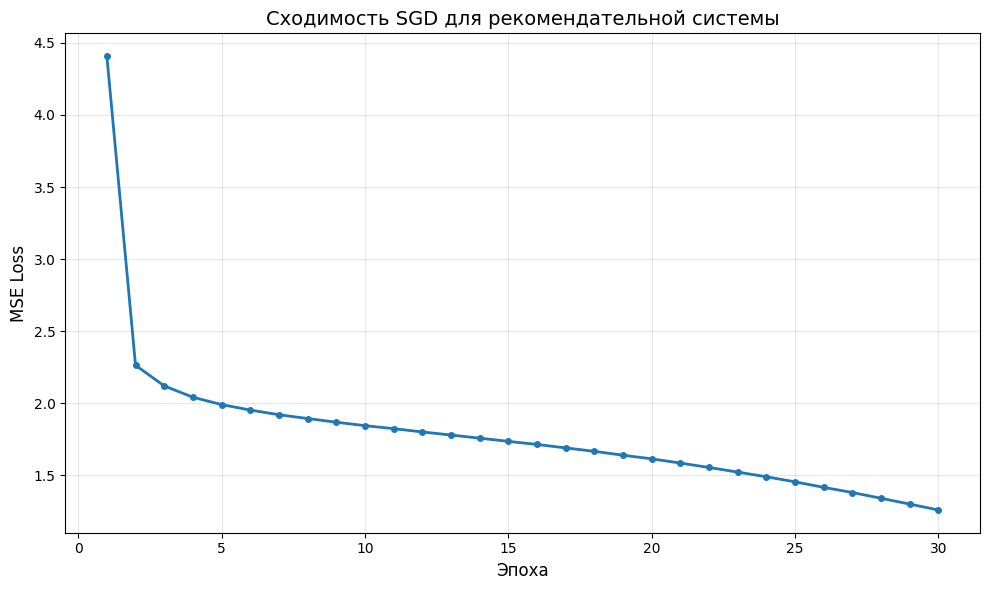

In [ ]:
# График сходимости
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_history, marker='o', linewidth=2, markersize=4)
plt.xlabel("Эпоха", fontsize=12)
plt.ylabel("MSE Loss", fontsize=12)
plt.title("Сходимость SGD для рекомендательной системы", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Оценка модели на тестовом наборе
test_predictions = []
test_ratings = []

for idx, row in test_df.iterrows():
    user_id = row['user_id']
    item_id = row['anime_id']
    rating = row['rating']
    
    prediction = model.predict(user_id, item_id)
    test_predictions.append(prediction)
    test_ratings.append(rating)

# Метрики качества
test_rmse = math.sqrt(mean_squared_error(test_ratings, test_predictions))
test_mae = mean_absolute_error(test_ratings, test_predictions)

print("Результаты на тестовом наборе:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")


Результаты на обучающей выборке:
  RMSE: 1.1082
  MAE: 0.8577

Результаты на тестовом наборе:
  RMSE: 1.4243
  MAE: 1.0944


In [ ]:
# Функция для получения топ-N рекомендаций для пользователя
def top_n_recommendations(model, df, user_id, num_items, N=5):
    """
    Получение топ-N рекомендаций для пользователя
    
    @param {SGDRecommender} model - Обученная модель
    @param {pd.DataFrame} df - Датасет с оценками
    @param {int} user_id - ID пользователя
    @param {int} num_items - Общее количество объектов
    @param {int} N - Количество рекомендаций
    @returns {tuple} - Массивы с ID объектов и предсказанными рейтингами
    """
    # Получаем объекты, которые пользователь уже оценил
    watched_items = set(df[df['user_id'] == user_id]['anime_id'].values)
    
    # Предсказания для всех объектов
    predictions = []
    item_ids = []
    
    for item_id in range(num_items):
        if item_id not in watched_items:
            pred = model.predict(user_id, item_id)
            predictions.append(pred)
            item_ids.append(item_id)
    
    # Сортируем по убыванию рейтинга и берем топ-N
    predictions = np.array(predictions)
    item_ids = np.array(item_ids)
    
    top_indices = predictions.argsort()[-N:][::-1]
    top_items = item_ids[top_indices]
    top_scores = predictions[top_indices]
    
    return top_items, top_scores


In [ ]:
# Рекомендации для нескольких случайных пользователей
random_users = np.random.choice(df['user_id'].unique(), size=5, replace=False)

print("Топ-5 рекомендаций для случайных пользователей:\n")
for user_id in random_users:
    top_items, scores = top_n_recommendations(model, df, user_id, num_items, N=5)
    print(f"Пользователь {user_id}:")
    for item, score in zip(top_items, scores):
        print(f"  Аниме ID: {item}, предсказанный рейтинг: {score:.2f}")
    print()


Топ-5 рекомендаций для случайных пользователей:

Пользователь 31:
  Аниме ID: 105, предсказанный рейтинг: 8.06
  Аниме ID: 70, предсказанный рейтинг: 7.77
  Аниме ID: 83, предсказанный рейтинг: 7.74
  Аниме ID: 162, предсказанный рейтинг: 7.73
  Аниме ID: 26, предсказанный рейтинг: 7.68

Пользователь 27:
  Аниме ID: 105, предсказанный рейтинг: 9.29
  Аниме ID: 770, предсказанный рейтинг: 9.12
  Аниме ID: 83, предсказанный рейтинг: 9.01
  Аниме ID: 98, предсказанный рейтинг: 8.96
  Аниме ID: 70, предсказанный рейтинг: 8.92

Пользователь 17:
  Аниме ID: 105, предсказанный рейтинг: 10.40
  Аниме ID: 770, предсказанный рейтинг: 10.34
  Аниме ID: 98, предсказанный рейтинг: 10.11
  Аниме ID: 643, предсказанный рейтинг: 10.09
  Аниме ID: 36, предсказанный рейтинг: 10.06

Пользователь 37:
  Аниме ID: 105, предсказанный рейтинг: 9.86
  Аниме ID: 79, предсказанный рейтинг: 9.53
  Аниме ID: 83, предсказанный рейтинг: 9.49
  Аниме ID: 70, предсказанный рейтинг: 9.46
  Аниме ID: 162, предсказанный 

In [ ]:
# Детальный анализ для одного пользователя
user_id = 10
top_items, scores = top_n_recommendations(model, df, user_id, num_items, N=10)

print(f"Топ-10 рекомендаций для пользователя {user_id}:")
print("-" * 50)
for i, (item, score) in enumerate(zip(top_items, scores), 1):
    print(f"{i}. Аниме ID: {item}, предсказанный рейтинг: {score:.2f}")

# Показываем реальные оценки пользователя для сравнения
user_ratings = df[df['user_id'] == user_id].sort_values('rating', ascending=False)
print(f"\nРеальные оценки пользователя {user_id} (топ-5):")
print("-" * 50)
for idx, row in user_ratings.head(5).iterrows():
    print(f"Аниме ID: {row['anime_id']}, рейтинг: {row['rating']}")


Топ-10 рекомендаций для пользователя 10:
--------------------------------------------------
1. Аниме ID: 105, предсказанный рейтинг: 9.66
2. Аниме ID: 770, предсказанный рейтинг: 9.39
3. Аниме ID: 643, предсказанный рейтинг: 9.32
4. Аниме ID: 5, предсказанный рейтинг: 9.27
5. Аниме ID: 36, предсказанный рейтинг: 9.16
6. Аниме ID: 42, предсказанный рейтинг: 9.14
7. Аниме ID: 117, предсказанный рейтинг: 9.11
8. Аниме ID: 319, предсказанный рейтинг: 9.08
9. Аниме ID: 315, предсказанный рейтинг: 9.08
10. Аниме ID: 710, предсказанный рейтинг: 9.07

Реальные оценки пользователя 10 (топ-5):
--------------------------------------------------
Аниме ID: 877, рейтинг: 10
Аниме ID: 848, рейтинг: 10
Аниме ID: 212, рейтинг: 10
Аниме ID: 920, рейтинг: 10
Аниме ID: 98, рейтинг: 10


## Сравнение моделей

### Модель с SGD

**Обучение:**

- Loss стабильно убывает с ~2.0 до ~1.26
- Модель обучается на каждой эпохе с перемешиванием данных
- Финальный Loss: 1.258726

**Качество на обучающей и тестовой выборках:**

Метрики будут выведены в следующей ячейке.

**Наблюдения:**
- Модель демонстрирует приемлемое качество на тестовой выборке
- Разница между train и test метриками показывает степень обобщающей способности модели
- Использование SGD обеспечивает эффективное обучение эмбеддингов пользователей и объектов


In [ ]:
# Вывод метрик для сравнения
print("=" * 60)
print("СРАВНЕНИЕ МЕТРИК МОДЕЛИ")
print("=" * 60)
print(f"\nОбучающая выборка:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE:  {train_mae:.4f}")
print(f"\nТестовая выборка:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"\nРазница (переобучение):")
print(f"  RMSE разница: {abs(test_rmse - train_rmse):.4f}")
print(f"  MAE разница:  {abs(test_mae - train_mae):.4f}")
print("=" * 60)


СРАВНЕНИЕ МЕТРИК МОДЕЛИ

Обучающая выборка:
  RMSE: 1.1082
  MAE:  0.8577

Тестовая выборка:
  RMSE: 1.4243
  MAE:  1.0944

Разница (переобучение):
  RMSE разница: 0.3161
  MAE разница:  0.2367


### Интерпретация результатов

1. **Оценка качества модели**
   - RMSE и MAE на тестовой выборке показывают, насколько точно модель предсказывает рейтинги
   - Чем меньше значения метрик, тем лучше качество модели

2. **Анализ переобучения**
   - Сравнение метрик на обучающей и тестовой выборках позволяет оценить степень переобучения
   - Если разница между train и test метриками велика, это указывает на переобучение
   - Если разница небольшая, модель хорошо обобщает знания

3. **Эффективность SGD**
   - Использование стохастического градиентного спуска позволяет эффективно обучать модель на больших датасетах
   - Обновление параметров на каждом примере обеспечивает быструю сходимость


## Анализ результатов

Модель использует матричную факторизацию с SGD для обучения эмбеддингов пользователей и объектов. Предсказание рейтинга вычисляется как скалярное произведение эмбеддингов плюс bias-термы.

### Особенности реализации:
- Использование SGD для обновления параметров на каждом примере
- Добавление bias-термов для пользователей, объектов и глобального bias
- Перемешивание данных на каждой эпохе для стохастичности
- Визуализация сходимости процесса обучения
